In [5]:
import pandas as pd
import numpy as np
import h5py
import sys 
import glob

import matplotlib.pyplot as plt
import scipy.io

sys.path.append('/home/lugeon/eeg_project/scripts')


In [2]:
with np.load('/mlodata1/lugeon/dream_data/processed/healthy/images/H009.npz') as images:
    for k in images:
        print(k)

H009_E1_NREM_S03.img
H009_E1_NREM_S05.img
H009_E1_NREM_S06.img
H009_E1_NREM_S07.img
H009_E1_NREM_S09.img
H009_E1_REM_S04.img
H009_E1_REM_S08.img
H009_E1_REM_S12.img
H009_E2_NREM_S01.img
H009_E2_NREM_S07.img
H009_E2_NREM_S08.img
H009_E2_NREM_S09.img
H009_E1_NREM_S01.img
H009_E1_NREM_S02.img


In [3]:
with np.load('/mlodata1/lugeon/dream_data/processed/healthy/images/H009.npz') as images:
    h018 = images['H009_E1_REM_S12.img']

h018.shape

(237, 5, 32, 32)

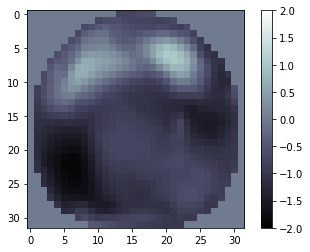

In [15]:
fig, ax = plt.subplots()
shw = ax.imshow(h018[1, 2, :, :], cmap='bone', vmin=-2, vmax=2);
bar = plt.colorbar(shw)

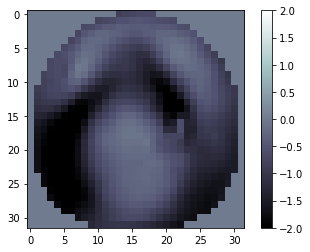

In [6]:
fig, ax = plt.subplots()
shw = ax.imshow(h018[0, 1, :, :], cmap='bone', vmin=-2, vmax=2);
bar = plt.colorbar(shw)

In [7]:
with h5py.File('/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/hdf5/32_32_FFT_data_all_bands_120s_20sbj_log_z-score_stages23') as f:
    for k in f:
        print(f[k])

<HDF5 dataset "fileindexes": shape (94326,), type "<f4">
<HDF5 dataset "images": shape (94326, 5, 32, 32), type "<f4">
<HDF5 dataset "labels": shape (94326,), type "<f4">
<HDF5 dataset "subfileindexes": shape (94326,), type "<f4">
<HDF5 dataset "subjects": shape (94326,), type "|S4">


In [3]:
with h5py.File('/mlodata1/lugeon/dream_data/processed/healthy/dataset_small.h5') as f:
    for k in f:
        print(f[k])

    frame_id = f['frame_id'][:]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    images = f['images'][:]
    labels = f['labels'][:]

<HDF5 dataset "frame_id": shape (2370,), type "<f4">
<HDF5 dataset "images": shape (2370, 5, 32, 32), type "<f4">
<HDF5 dataset "labels": shape (2370,), type "<f4">
<HDF5 dataset "subject_id": shape (2370,), type "<f4">
<HDF5 dataset "subject_name": shape (20,), type "|S4">
<HDF5 dataset "trial_id": shape (2370,), type "<f4">


In [10]:
with h5py.File('/mlodata1/lugeon/dream_data/processed/healthy/dataset_small.h5') as f:

    df = pd.DataFrame({
                'sid': f['subject_id'][:], 
                'tid': f['trial_id'][:], 
                'fid': f['frame_id'][:]
                })

In [11]:
df.shape

(2370, 3)

In [19]:
sys.path.append('/home/lugeon/eeg_project/scripts')
from training.representation.dataset import EEG_Image_Batch_Dataset

In [67]:
import numpy as np

def identity(array):
    return array

def reverse(array):
    return array[:, ::-1]

def add_gaussian_noise(array, mean=0, std=1):
    return array + np.random.normal(mean, std, array.shape)

def permute_frames(array):
    return np.stack([np.random.permutation(vid) for vid in array])

def jitter_channels(array, low=0.5, high=2):
    """ Randomly multiply the amplitude of the channels, independently for each video.

    Args:
        array (_type_): _description_
        low (float, optional): _description_. Defaults to 0.5.
        high (int, optional): _description_. Defaults to 2.

    Returns:
        _type_: _description_
    """
    n_channels = array.shape[2]
    jittered = [
        np.swapaxes(
            np.swapaxes(vid, -1, 1) * np.random.uniform(low, high, n_channels), 
            -1, 1) 
        for vid in array
        ] # swap axes, broadcast, swap back
    
    return np.stack(jittered)

In [17]:
test_array = np.array([
    [
        [[1, -1], [1, -1]], # frame
        [[2, -2], [2, -2]]
    ],
    [
        [[3, -3], [3, -3]], 
        [[4, -4], [4, -4]]
    ]
])
test_array

array([[[[ 1, -1],
         [ 1, -1]],

        [[ 2, -2],
         [ 2, -2]]],


       [[[ 3, -3],
         [ 3, -3]],

        [[ 4, -4],
         [ 4, -4]]]])

In [28]:
batch_size, n_frames, _, _,  = test_array.shape

# one permutation per video
ix = np.arange(batch_size * n_frames).reshape(batch_size, n_frames)
np.apply_along_axis(np.random.shuffle, 1, ix)

# reshape and permute frames
per = test_array.reshape(batch_size * n_frames, -1)[ix.flatten(), :]

per.reshape(test_array.shape)

array([[[[ 2, -2],
         [ 2, -2]],

        [[ 1, -1],
         [ 1, -1]]],


       [[[ 3, -3],
         [ 3, -3]],

        [[ 4, -4],
         [ 4, -4]]]])

In [16]:
per = test_array.reshape(batch_size * n_frames, -1)
per

array([[ 1, -1,  1, -1],
       [ 2, -2,  2, -2],
       [ 3, -3,  3, -3],
       [ 4, -4,  4, -4]])

In [42]:
(test_array.swapaxes(1, 2).T * r).T.swapaxes(1, 2)

array([[[[ 0.80363034, -0.80363034],
         [ 0.98629269, -0.98629269]],

        [[ 1.60726068, -1.60726068],
         [ 1.97258537, -1.97258537]]],


       [[[ 1.51557317, -1.51557317],
         [ 2.21595764, -2.21595764]],

        [[ 2.02076423, -2.02076423],
         [ 2.95461018, -2.95461018]]]])

In [54]:
import yaml

txt = """ 
      - f: add_gaussian_noise
        kwargs:
          mean: 0
          std: 5
      - f: jitter_channels
        kwargs:
          low: 0.2
          high: 4
"""

transforms = yaml.load(txt, Loader=yaml.FullLoader)

In [61]:
txt = """ 
- f: add_gaussian_noise
  kwargs: {}
  
- f: jitter_channels
  kwargs:
    low: 0.2
    high: 4
"""

yaml.load(txt, Loader=yaml.FullLoader)

[{'f': 'add_gaussian_noise', 'kwargs': {}},
 {'f': 'jitter_channels', 'kwargs': {'low': 0.2, 'high': 4}}]

In [51]:
transforms

[{'name': 'add_gaussian_noise', 'kwargs': {'mean': 0, 'std': 5}},
 {'name': 'jitter_channels', 'kwargs': {'low': 0.2, 'high': 4}}]

In [52]:
sys.path.append('/home/lugeon/eeg_project/scripts')
from training.representation import cl_transforms

In [56]:
for t in transforms:
    t['f'] = getattr(cl_transforms, t['f'])

In [57]:
transforms

[{'f': <function training.representation.cl_transforms.add_gaussian_noise(array: <built-in function array>, mean: float = 0, std: float = 1)>,
  'kwargs': {'mean': 0, 'std': 5}},
 {'f': <function training.representation.cl_transforms.jitter_channels(array: <built-in function array>, low: float = 0.5, high: float = 2)>,
  'kwargs': {'low': 0.2, 'high': 4}}]

In [31]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy/dataset_small.h5'

dataset = EEG_Image_Batch_Dataset(hdf5_file, 
                                  window=20, 
                                  slide=5, 
                                  batch_size=64, 
                                  shuffle=False, 
                                  output_type='transform',
                                  transforms = [identity, reverse])

In [32]:
input, output = dataset[0]

In [33]:
input.shape

(64, 20, 5, 32, 32)

In [37]:
(input[0][::-1, :] == output[0][:]).all()

True

In [13]:
dataset[0][1].shape

(1896,)

In [42]:
len(dataset)

8

In [43]:
df.sid.value_counts()

19.0    474
0.0     237
3.0     237
4.0     237
5.0     237
7.0     237
11.0    237
15.0    237
18.0    237
Name: sid, dtype: int64

In [3]:
pd.read_csv('/mlodata1/lugeon/dream_data/chuv/baseline/rawdb_info.csv')

,file_path,file_name,subject,stage,trial_num
0,H009/REM_c3.mat,REM_c3.mat,H009,REM,c3.mat
1,H009/REM_c4.mat,REM_c4.mat,H009,REM,c4.mat
2,H009/NREM_c1.mat,NREM_c1.mat,H009,NREM,c1.mat
3,H009/NREM_c2.mat,NREM_c2.mat,H009,NREM,c2.mat
4,H009/NREM_c3.mat,NREM_c3.mat,H009,NREM,c3.mat
...,...,...,...,...,...
156,H061/REM_c1.mat,REM_c1.mat,H061,REM,c1.mat
157,H061/REM_c2.mat,REM_c2.mat,H061,REM,c2.mat
158,H061/REM_c3.mat,REM_c3.mat,H061,REM,c3.mat
159,H061/REM_c4.mat,REM_c4.mat,H061,REM,c4.mat


In [7]:
with h5py.File('/mlodata1/lugeon/dream_data/chuv/baseline/Info/H009/INFO_NREM_c1.mat') as f:
    for k in f:
        print(k)

cepo
cpoints
id_epo1
id_epo2
orig_fs
pt_arousals
scoring


In [10]:
with h5py.File('/mlodata1/lugeon/dream_data/chuv/baseline/Info/H009/INFO_NREM_c1.mat') as f:
    scoring = f['scoring'][:]

In [12]:
scoring.shape

(863, 1)

In [14]:
import torch
sys.path.append('/home/lugeon/eeg_project/scripts')
from training.representation.models import ContrastiveResNet18

cl = ContrastiveResNet18(
    dropout=0.5,
    encoding_dim=100,
    projection_dim=32,
    time_filter_dim=5,
    n_time_filters=64,
    n_channels=5,
    n_frames=20,
)

In [2]:
toy_input = torch.ones(64, 20, 5, 32, 32)

In [3]:
cl(toy_input).size()

torch.Size([64, 32])

In [5]:
cl.encode(toy_input).size()

torch.Size([64, 100])

In [16]:
from training.representation import losses

In [17]:
loss_function = getattr(losses, 'ContrastiveLoss', None)

In [18]:
loss_function

training.representation.losses.ContrastiveLoss